In [52]:
!pip install ortools
!pip install folium
!pip install osmnx
!pip install networkx
!pip install plotly

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import osmnx as ox
import networkx as nx
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2


In [54]:
city = "London"
dtf=pd.read_csv('/content/sample_data/data_stores.csv')
dtf=dtf[dtf["City"]==city][ ["City", "Street Address", "Latitude", "Longitude"]].reset_index(drop=True)
dtf=dtf.reset_index().rename(columns={"index":"id", "Latitude":"y", "Longitude":"x"})

print("total", len(dtf))
dtf.head(3)

total 216


,id,City,Street Address,y,x
0,0,London,265 Wharncliffe Rd North,42.99,-81.26
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22
2,2,London,631 Commissioners Road East,42.96,-81.23


In [55]:
data = dtf.copy()
data["color"]=''
data.loc[data['id']==0 , 'color'] = 'red'
data.loc[data['id']!=0 , 'color'] = 'black'
start=data[data["id"]==0][["y","x"]].values[0]
data.head(3)
print("starting point:" , start)

starting point: [ 42.99 -81.26]


In [56]:
map = folium.Map(location=start, tiles= "cartodbpositron", zoom_start=12)
data.apply(lambda row:
    folium.CircleMarker(
        location=[row["y"], row["x"]],
        color=row["color"], fill = True, radius=5).add_to(map), axis=1)

map

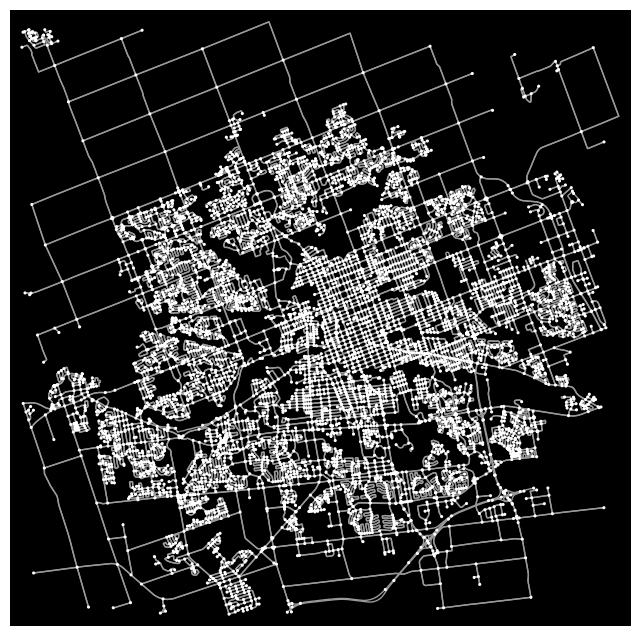

In [57]:
G=ox.graph_from_point(start, dist=10000, network_type="drive")
G=ox.add_edge_speeds(G)
G=ox.add_edge_travel_times(G)
fig,ax = ox.plot_graph(G, bgcolor="black", node_size=5 , node_color="white", figsize=(16,8))

In [58]:
start_node=ox.distance.nearest_nodes(G, start[1], start[0])
dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
dtf=dtf.drop_duplicates("node", keep='first')
dtf.head()

<ipython-input-58-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-58-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["node"]=dtf[["y", "x"]].apply(lambda x: ox.distance.nearest_nodes(G, x[1], x[0]), axis=1)
<ipython-input-58-3f563add5754>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dtf["

,id,City,Street Address,y,x,node
0,0,London,265 Wharncliffe Rd North,42.99,-81.26,289796441
1,1,London,"1105 Wellington Rd., Store No. 122",42.93,-81.22,324811692
2,2,London,631 Commissioners Road East,42.96,-81.23,11756886360
3,3,London,1442 Fanshawe Park Road,43.01,-81.34,252974916
4,4,London,"580 Fanshawe Park Road East, Unit 1, White Oak...",43.03,-81.26,302754873


In [59]:
def f(a , b):
    try:
        d=nx.shortest_path_length(G, source=a, target=b, method='dijkstra', weight='travel_time')
    except:
        d=np.nan
    return d

distance_matrix=np.asarray([[f(a,b)for b in dtf["node"].tolist()] for a in dtf["node"].tolist()])
distance_matrix=pd.DataFrame(distance_matrix, columns=dtf["node"].values, index=dtf["node"].values)

distance_matrix.head()

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0.000000,562.838547,353.021140,594.714108,498.753566,403.372848,126.526883,393.757943,554.836209,101.783522,514.114398,435.279786,233.310487,198.958381,567.047200,226.242148,522.900023,477.118581,1034.600392,1046.958213
324811692,590.165537,0.000000,210.854848,1099.746932,950.667034,713.164777,458.105718,871.443311,736.595120,489.689320,402.674074,890.422276,670.104661,403.238530,680.668690,777.532673,119.618320,982.151405,1311.267733,782.619710
11756886360,379.310690,209.817407,0.000000,913.372457,739.812187,579.110372,247.250870,660.588464,550.220645,278.834473,412.490165,704.047801,459.249813,192.383682,582.545396,579.312318,239.874876,795.776930,1201.653649,914.970604
252974916,592.990749,1096.634969,915.098467,0.000000,428.968783,858.414701,704.884633,323.973160,481.421944,665.852269,725.883096,356.003522,500.976889,764.564436,1083.558828,433.002048,1026.217304,174.877312,1306.567527,979.702479
302754873,498.676846,951.689073,741.871666,429.978266,0.000000,480.687036,573.154945,107.366297,892.037276,513.646688,865.033078,764.752534,348.771309,568.950285,705.831163,395.050187,981.485324,312.382740,928.839862,1390.317812


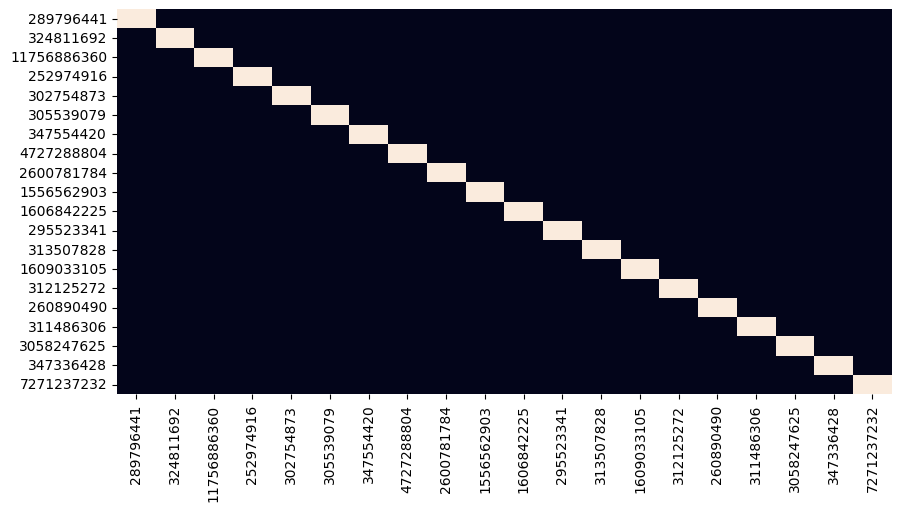

In [60]:
heatmap= distance_matrix.copy()
for col in heatmap.columns:
    heatmap[col]=heatmap[col].apply(lambda x:
         0.3 if pd.isnull(x) else
         (0.7 if np.isinf(x) else
          (0 if x!=0 else 1)) )

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(heatmap, vmin=0 , vmax=1 , cbar=False, ax=ax)
plt.show()

In [61]:
distance_matrix= distance_matrix.round()
distance_matrix=distance_matrix.astype('int')
distance_matrix

,289796441,324811692,11756886360,252974916,302754873,305539079,347554420,4727288804,2600781784,1556562903,1606842225,295523341,313507828,1609033105,312125272,260890490,311486306,3058247625,347336428,7271237232
289796441,0,563,353,595,499,403,127,394,555,102,514,435,233,199,567,226,523,477,1035,1047
324811692,590,0,211,1100,951,713,458,871,737,490,403,890,670,403,681,778,120,982,1311,783
11756886360,379,210,0,913,740,579,247,661,550,279,412,704,459,192,583,579,240,796,1202,915
252974916,593,1097,915,0,429,858,705,324,481,666,726,356,501,765,1084,433,1026,175,1307,980
302754873,499,952,742,430,0,481,573,107,892,514,865,765,349,569,706,395,981,312,929,1390
305539079,403,645,583,861,485,0,436,539,894,376,867,767,411,410,309,558,747,744,688,1362
347554420,150,456,246,716,572,435,0,467,520,92,479,518,265,93,491,350,425,598,1067,1012
4727288804,391,869,659,323,107,537,466,0,785,406,758,657,241,505,762,288,874,205,985,1283
2600781784,555,732,550,478,887,890,521,782,0,603,361,185,720,578,1002,563,662,633,1521,633
1556562903,170,488,278,668,512,376,92,407,603,0,562,538,206,124,492,336,501,551,1007,1095


In [62]:
drivers = 1
lst_nodes= dtf["node"].tolist()
print("start:", start_node, "total locations to visit", len(lst_nodes)-1, "drivers", drivers)

start: 289796441 total locations to visit 19 drivers 1


In [63]:
manager= pywrapcp.RoutingIndexManager(len(lst_nodes), drivers, lst_nodes.index(start_node))
model=pywrapcp.RoutingModel(manager)

In [64]:
def get_distance(from_index, to_index):
    return distance_matrix.iloc[from_index, to_index]

distance=model.RegisterTransitCallback(get_distance)
model.SetArcCostEvaluatorOfAllVehicles(distance)

parameters = pywrapcp.DefaultRoutingSearchParameters()
parameters.first_solution_strategy= (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

In [65]:
solution= model.SolveWithParameters(parameters)

index=model.Start(0)
print('route for driver:')
route_idx, route_distance = [], 0

while not model.IsEnd(index):
    route_idx.append(manager.IndexToNode(index))
    previous_index=index
    index=solution.Value(model.NextVar(index))

    try:
        route_distance +=get_distance(previous_index, index)
    except:
        route_distance+=model.GetArcCostForVehicle(from_index=previous_index, to_index=index, vehicle=0)

print(route_idx)
print(f'Total distance:{round(route_distance/1000,2)}km')
print(f'Nodes visited: {len(route_idx)}')

route for driver:
[0, 6, 9, 13, 2, 1, 16, 10, 8, 11, 3, 17, 7, 4, 12, 15, 5, 14, 18, 19]
Total distance:6.69km
Nodes visited: 20


In [66]:
print("Route for driver (nodes):")
lst_route=[lst_nodes[i] for i in route_idx]
print(lst_route)

Route for driver (nodes):
[289796441, 347554420, 1556562903, 1609033105, 11756886360, 324811692, 311486306, 1606842225, 2600781784, 295523341, 252974916, 3058247625, 4727288804, 302754873, 313507828, 260890490, 305539079, 312125272, 347336428, 7271237232]


In [67]:


def get_path_between_nodes(lst_route, G):
    lst_paths = []
    for i in range(len(lst_route) - 1):  # Stop at the second last element
        a, b = lst_route[i], lst_route[i + 1]
        try:
            path = nx.shortest_path(G, source=a, target=b, method='dijkstra', weight='travel_time')
            if len(path) > 1:
                lst_paths.append(path)
        except nx.NetworkXNoPath:
            print(f"No path found between {a} and {b}")
        except nx.NodeNotFound:
            print(f"Node {a} or {b} not found in the graph")
    return lst_paths

# Assuming G is your graph and lst_route is your list of nodes
# Example: G = ox.graph_from_place('Your Place', network_type='drive')
# Example: lst_route = [node1, node2, node3, ...]

# Get the paths between nodes
lst_paths = get_path_between_nodes(lst_route, G)

# Initialize a Folium map at the center of the graph
# Calculate the centroid of the graph manually
nodes = ox.graph_to_gdfs(G, edges=False)
graph_center = nodes.unary_union.centroid
map = folium.Map(location=[graph_center.y, graph_center.x], zoom_start=15)

# Plot all paths on the map
for path in lst_paths:
    # Get the coordinates of the nodes in the path
    nodes_in_path = nodes.loc[path]
    locations = nodes_in_path[['y', 'x']].values.tolist()
    folium.PolyLine(locations=locations, color="blue", weight=5).add_to(map)

# Display the map
map

<ipython-input-67-3be1c5d18ff8>:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  graph_center = nodes.unary_union.centroid


In [68]:
def df_animation_multiple_path(G, lst_paths, parallel=True):
    df=pd.DataFrame()
    for path in lst_paths :
        lst_start, lst_end = [] , []
        start_x, start_y = [] , []
        end_x, end_y = [], []
        lst_length, lst_time = [], []

        for a , b in zip (path[:-1], path[1:]):
            lst_start.append(a)
            lst_end.append(b)
            lst_length.append(round(G.edges[(a,b,0)]['length']))
            lst_time.append(round(G.edges[(a,b,0)]['travel_time']))
            start_x.append(G.nodes[a]['x'])
            start_y.append(G.nodes[a]['y'])
            end_x.append(G.nodes[b]['x'])
            end_y.append(G.nodes[b]['y'])

        tmp=pd.DataFrame(list(zip(lst_start, lst_end, start_x, start_y, end_x, end_y, lst_length, lst_time)),
                         columns= ["start", "end", "start_x", "start_y", "end_x", "end_y", "length", "travel_time"])
        df=pd.concat([df,tmp], ignore_index=(not parallel))

    df=df.reset_index().rename(columns={"index":"id"})
    return df


In [69]:
df= pd.DataFrame()
tmp=df_animation_multiple_path(G, lst_paths, parallel=False)
df=pd.concat([df, tmp], axis=0)
first_node, last_node= lst_paths[0][0], lst_paths[-1][-1]

In [70]:
df_start= df[df["start"]== first_node]
df_end=df[df["end"]== last_node]

fig=px.scatter_mapbox(data_frame=df, lon="start_x", lat="start_y", zoom=15, width=900, height=700, animation_frame="id",mapbox_style="carto-positron")

fig.data[0].marker={"size":12}

fig.add_trace(px.scatter_mapbox(data_frame=dtf, lon="x", lat="y").data[0])
fig.data[1].marker={"size":10, "color":"black"}

fig.add_trace(px.scatter_mapbox(data_frame=df_start, lon="start_x", lat="start_y").data[0])
fig.data[2].marker={"size":15, "color":"red"}

fig.add_trace(px.scatter_mapbox(data_frame=df_end, lon="start_x", lat="start_y").data[0])
fig.data[3].marker={"size":15, "color":"green"}

fig.add_trace(px.line_mapbox(data_frame=df, lon="start_x", lat="start_y").data[0])

fig

